In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [59]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data[:5000]
mnist_train.targets = mnist_train.targets[:5000]

mnist_test.data = mnist_test.data[:500]
mnist_test.targets = mnist_test.targets[:500]


In [60]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
#create a cnn architecture
class Teacher_CNN(nn.Module):
    def __init__(self):
        super(Teacher_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [63]:
#create the model
teacher_model = Teacher_CNN()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
teacher_loss = nn.CrossEntropyLoss()
teacher_model.to(device)

Teacher_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [79]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp=100
    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.to(device)
                y = y.to(device)
                
            optimizer.zero_grad()
            y_pred = model(X)
            
            y_pred = nn.functional.softmax(y_pred/temp, dim=1)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.to(device)
                    y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.to(device)
                    y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [80]:
#train the teacher model
traing_accs, test_accs = train_model(teacher_model, train_loader, test_loader, teacher_optimizer, teacher_loss, 5, CUDA=True)

Epoch 1, Training Accuracy: 0.8456, Validation Accuracy: 0.82
Epoch 2, Training Accuracy: 0.8926, Validation Accuracy: 0.88
Epoch 3, Training Accuracy: 0.9086, Validation Accuracy: 0.89
Epoch 4, Training Accuracy: 0.906, Validation Accuracy: 0.892
Epoch 5, Training Accuracy: 0.8934, Validation Accuracy: 0.884


In [103]:
#Create a new dataset with the teacher model predictions
teacher_model.eval()
teacher_input = []
teacher_predicted_probailities = []
temp = 10
with torch.no_grad():
    for X, y in train_loader:
        y_pred = teacher_model(X)
        teacher_input.append(X)
        y_pred = nn.functional.softmax(y_pred/temp, dim=1)
        teacher_predicted_probailities.append(y_pred)
        
teacher_input = torch.cat(teacher_input)
teacher_predicted_probailities = torch.cat(teacher_predicted_probailities)

In [104]:
#create new dataset
teacher_dataset = torch.utils.data.TensorDataset(teacher_input, teacher_predicted_probailities)
teacher_loader = torch.utils.data.DataLoader(teacher_dataset, batch_size=100, shuffle=True)

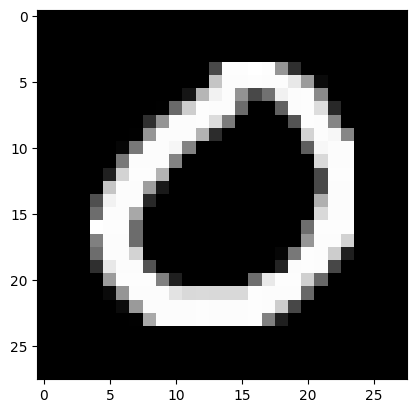

In [109]:
f = 80
#plot the first image

plt.imshow(teacher_input[f].squeeze().numpy(), cmap='gray')
plt.show()

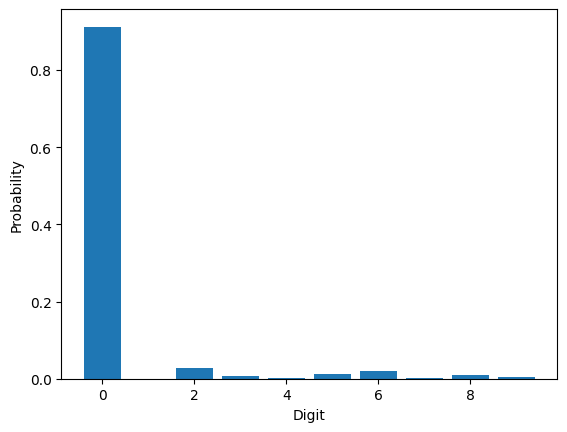

array([9.1207647e-01, 2.8180762e-04, 2.9062180e-02, 6.6211889e-03,
       1.0108160e-03, 1.1888983e-02, 2.0711577e-02, 2.7771366e-03,
       1.0733177e-02, 4.8365486e-03], dtype=float32)

In [110]:
#plot the first image probabilities
plt.bar(range(10), teacher_predicted_probailities[f].numpy())
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

teacher_predicted_probailities[f].numpy()


In [ ]:
#create a cnn architecture
class Student_CNN(nn.Module):
    def __init__(self):
        super(Student_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [111]:
#create student model
student_model = Teacher_CNN()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_loss = nn.KLDivLoss()

In [215]:
def train_model_student(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp = 400

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(X)
            
            y_pred = nn.functional.log_softmax(y_pred/temp, dim=1)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                _, true_classes = torch.max(y, dim=1)
                
                total += y.size(0)
                correct += (predicted == true_classes).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [216]:
#create random tensor
random_tensor = torch.rand(10, 2)
print(random_tensor)
a, b = torch.max(random_tensor, 1)

print(a,b)

tensor([[0.9988, 0.4422],
        [0.6612, 0.9137],
        [0.8185, 0.2372],
        [0.1279, 0.4009],
        [0.4371, 0.4857],
        [0.9421, 0.7817],
        [0.8901, 0.6718],
        [0.7751, 0.8543],
        [0.6138, 0.0493],
        [0.4531, 0.7571]])
tensor([0.9988, 0.9137, 0.8185, 0.4009, 0.4857, 0.9421, 0.8901, 0.8543, 0.6138,
        0.7571]) tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 1])


In [217]:
#train the student model
traing_accs, test_accs = train_model_student(student_model, teacher_loader, test_loader, student_optimizer, student_loss, 30)

Epoch 1, Training Accuracy: 0.6604, Validation Accuracy: 0.538
Epoch 2, Training Accuracy: 0.7664, Validation Accuracy: 0.674
Epoch 3, Training Accuracy: 0.8314, Validation Accuracy: 0.754
Epoch 4, Training Accuracy: 0.8542, Validation Accuracy: 0.776
Epoch 5, Training Accuracy: 0.8686, Validation Accuracy: 0.786
Epoch 6, Training Accuracy: 0.8806, Validation Accuracy: 0.794
Epoch 7, Training Accuracy: 0.8804, Validation Accuracy: 0.796
Epoch 8, Training Accuracy: 0.8864, Validation Accuracy: 0.8
Epoch 9, Training Accuracy: 0.8926, Validation Accuracy: 0.806
Epoch 10, Training Accuracy: 0.8988, Validation Accuracy: 0.81
Epoch 11, Training Accuracy: 0.902, Validation Accuracy: 0.814
Epoch 12, Training Accuracy: 0.9068, Validation Accuracy: 0.82
Epoch 13, Training Accuracy: 0.9066, Validation Accuracy: 0.82
Epoch 14, Training Accuracy: 0.9134, Validation Accuracy: 0.828
Epoch 15, Training Accuracy: 0.917, Validation Accuracy: 0.828
Epoch 16, Training Accuracy: 0.9184, Validation Accuracy

In [115]:
from fgsm import create_fgsm_adversarial_example
from fgsm import can_import

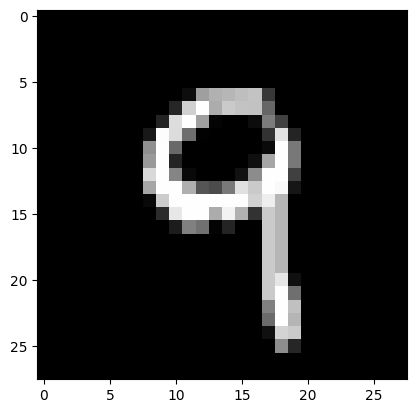

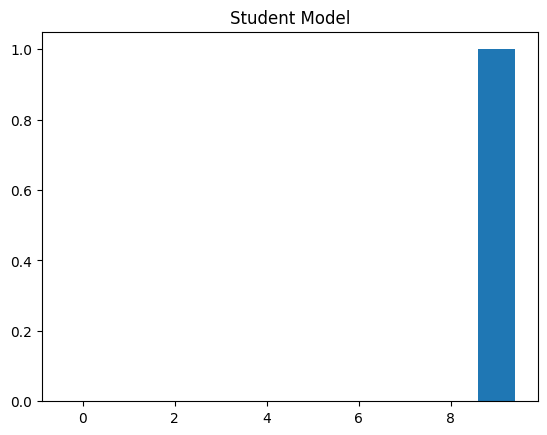

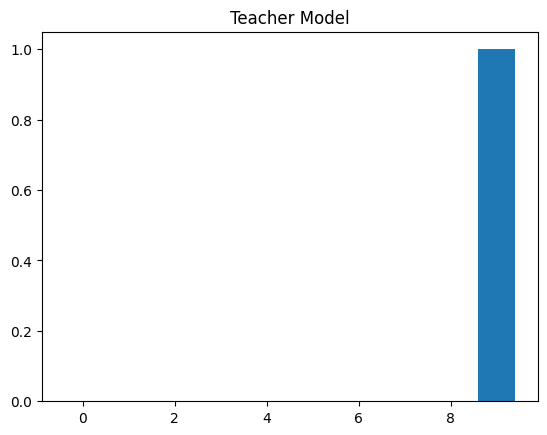

In [218]:
#get image from the test set
for X, y in train_loader:
    #get prediction from the student model
    y_pred_student = student_model(X)
    y_pred_teacher = teacher_model(X)
    
    #plot the image
    plt.imshow(X[0].squeeze().numpy(), cmap='gray')
    plt.show()
    
    #plot both predictions
    plt.bar(range(10), nn.functional.softmax(y_pred_student[0], dim=0).detach().numpy())
    plt.title('Student Model')
    plt.show()
    
    plt.bar(range(10), nn.functional.softmax(y_pred_teacher[0], dim=0).detach().numpy())
    plt.title('Teacher Model')
    plt.show()
    
    break

In [219]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    x_grad = X.grad.data
    x_adv = X + epsilon * x_grad.sign()
    return model_prediction_unperturbed, prediction_confidence, x_adv

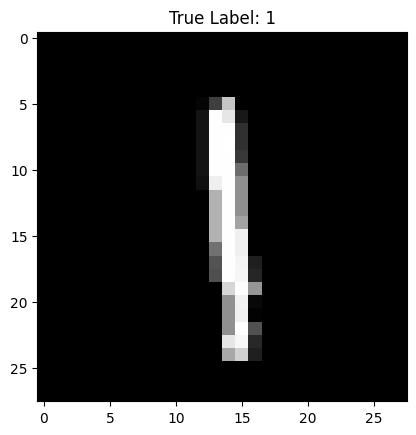

In [220]:
a =8
#create an adversarial example
input_label = train_loader.dataset[a][1]

#convert y to tensor
y_tensor = torch.tensor([input_label])

model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, train_loader.dataset[a][0], y_tensor, epsilon=0.1)


#plot the orginal image
plt.imshow(train_loader.dataset[a][0].squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {input_label}')
plt.show()

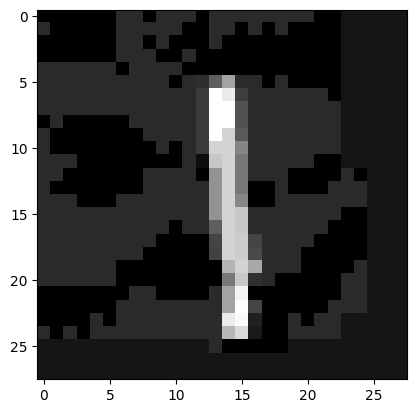

In [221]:
#plot the adversarial image
plt.imshow(x_adv.squeeze().detach().numpy(), cmap='gray')

In [222]:
print(x_adv.shape)

torch.Size([1, 28, 28])


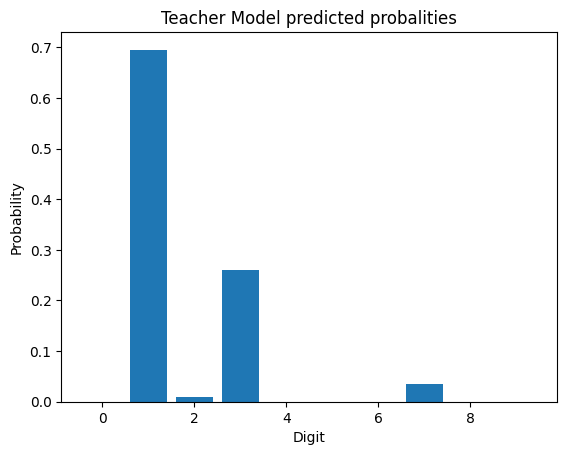

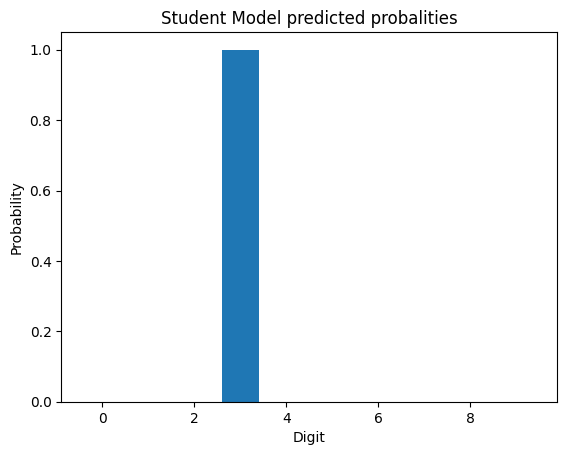

In [223]:
#make a prediction on the orginal image
teacher_output = teacher_model(x_adv)
#apply softmax
teacher_output = F.softmax(teacher_output, dim=1)
#convert to numpy array
teacher_output = teacher_output.detach().numpy()
#plot student output
plt.bar(range(10), teacher_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Teacher Model predicted probalities")
plt.show()

student_output = student_model(x_adv)
# apply softmax
student_output = F.softmax(student_output, dim=1)
# convert to numpy array
student_output = student_output.detach().numpy()

# plot student output
plt.bar(range(10), student_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Student Model predicted probalities")
plt.show()


### We can see here that the teach model incorrectly predicts class 2 for the image whereas the student model is able to correctly classify the perturbed image. This is a clear indication that the student model is more robust to adversarial attacks than the teacher model.

In [224]:
def evaluate_model_on_adversarial_input(model, model_criterion, test_dataloader, epsilon=0.1):
    
    #set batch size of 1
    test_dataloader = torch.utils.data.DataLoader(test_dataloader.dataset, batch_size=1, shuffle=False)
    
    raw_image_prections = []
    adv_image_predictions = []
    true_labels = []
    
    for X, y in test_dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        true_labels.append(y)
        
        #get the predictions on the raw image
        raw_image_prediction = model(X)
        _, raw_image_predicted = torch.max(raw_image_prediction.data, 1)
        raw_image_prections.append(raw_image_predicted)
        
        #create adversarial example
        _, _, x_adv = create_fgsm_adversarial_example(model, model_criterion, X, y, epsilon)
        
        #get the predictions on the adversarial image
        adv_image_prediction = model(x_adv)
        _, adv_image_predicted = torch.max(adv_image_prediction.data, 1)
        adv_image_predictions.append(adv_image_predicted)
            
    #concatenate the predictions
    raw_image_prections = torch.cat(raw_image_prections)
    adv_image_predictions = torch.cat(adv_image_predictions)
    true_labels = torch.cat(true_labels)
                
    return raw_image_prections, adv_image_predictions, true_labels

In [225]:
#evaluate accuracy for a range of epsilon values

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
student_accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    student_accuracies.append((raw_image_accuracy, adv_image_accuracy))

In [226]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
teacher_accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    teacher_accuracies.append((raw_image_accuracy, adv_image_accuracy))

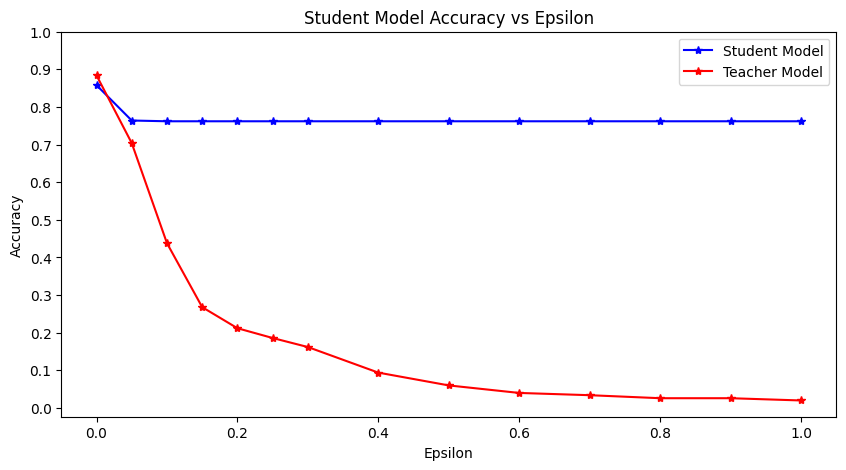

In [227]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[1] for a in student_accuracies], 'b*-', label='Student Model')
plt.plot(epsilons, [a[1] for a in teacher_accuracies], 'r*-', label='Teacher Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Student Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

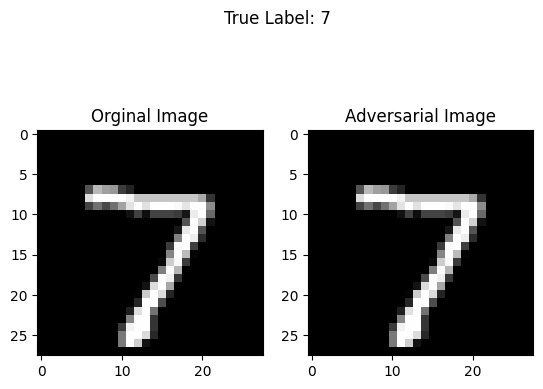

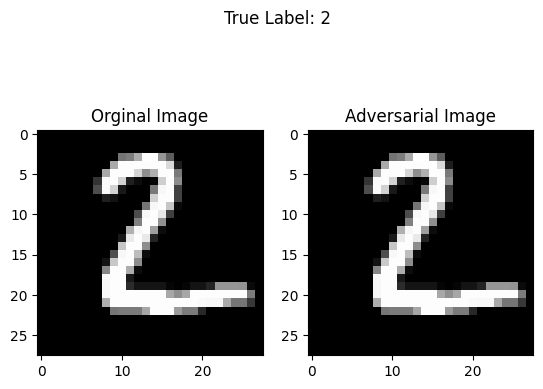

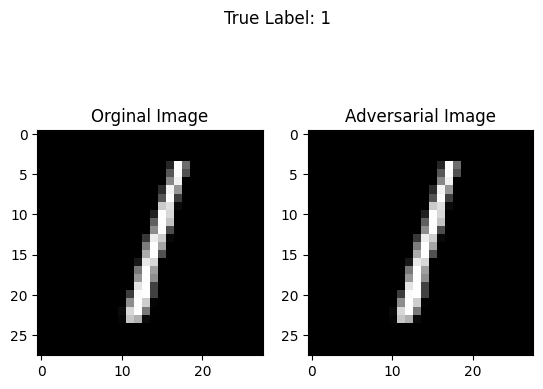

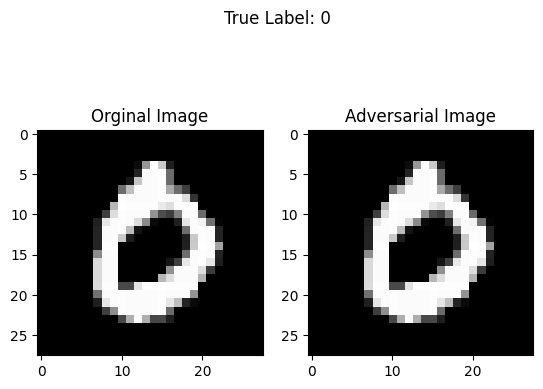

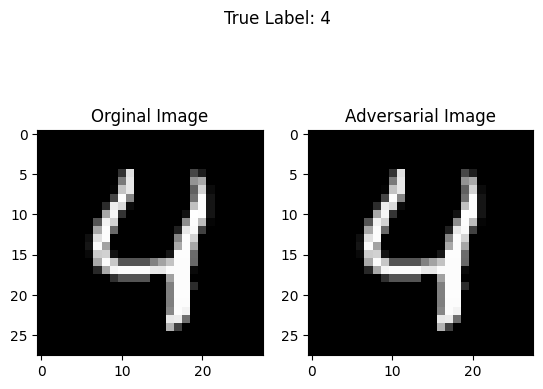

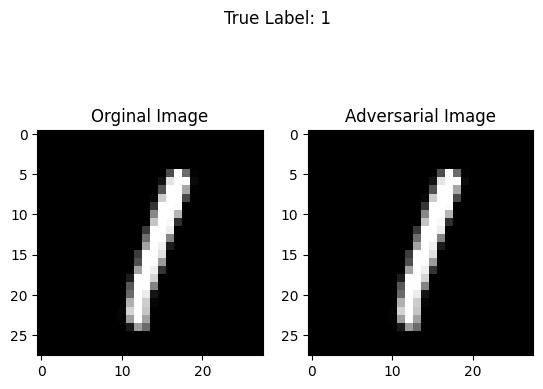

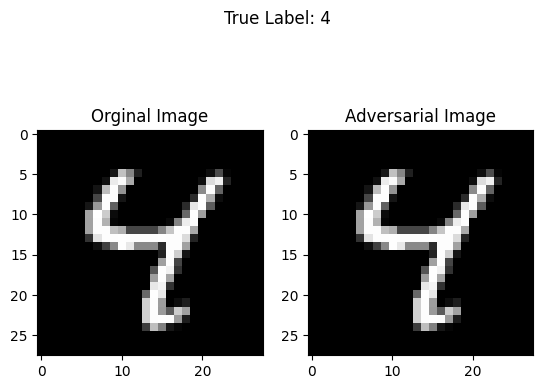

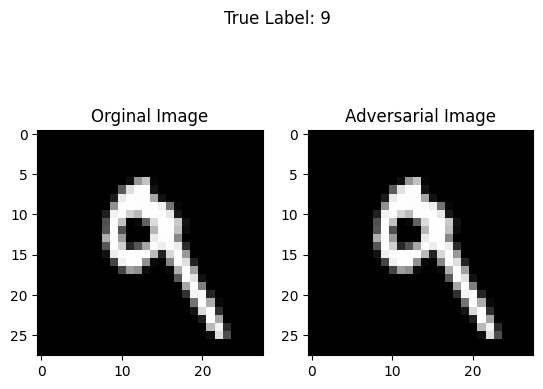

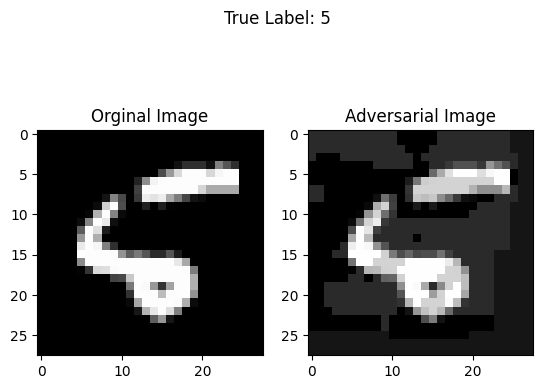

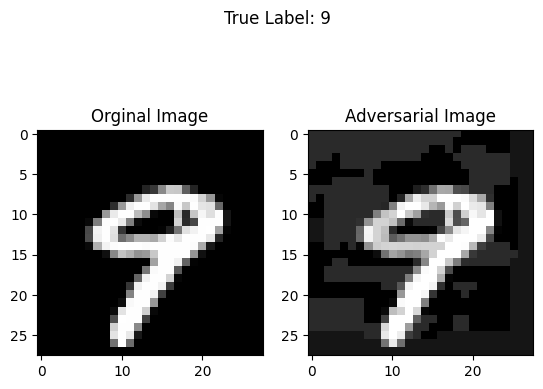

In [234]:
#create adverarial input for the first image in the test set

#set batch size of 1
final_test_dataloader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=1, shuffle=False)

counter = 0
for X, y in final_test_dataloader:
    if counter == 10:
        break
    counter += 1
    #create adversarial example
    _, _, x_adv = create_fgsm_adversarial_example(student_model, student_loss, X, y, epsilon=0.1)
    
    #plot the orginal image and adv side by side
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"True Label: {y.item()}")
    axs[0].imshow(X.detach().squeeze().numpy(), cmap='gray')
    axs[0].set_title('Orginal Image')
    axs[1].imshow(x_adv.squeeze().detach().numpy(), cmap='gray')
    axs[1].set_title('Adversarial Image')
    plt.show()
    